In [1]:
import subprocess
import sys
print("🔁 Installing/updating timm...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "timm>=1.0.22", "--quiet"])

import os
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')


🔁 Installing/updating timm...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was a

In [2]:
DATASET_ROOT = Path("/kaggle/input/fuckoff")  # <-- ganti "safeface" jika nama dataset berbeda
TRAIN_DIR = Path("/kaggle/input/fuckoff/train3-20251130T102637Z-1-001/train3")
VAL_DIR = Path("/kaggle/input/fuckoff/val3-20251130T102639Z-1-001/val3")
OUTPUT_DIR = Path("/kaggle/working/fuckoff")   # <-- nama folder output: "fuckoff"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
IMG_SIZE = 384
BATCH_SIZE = 24          # Naik sedikit karena model lebih kecil
EPOCHS = 25              # Cukup untuk konvergen
LR_WARMUP = 5e-4
LR_FINETUNE = 5e-6       # Lebih kecil untuk fine-grained
WEIGHT_DECAY = 1e-4
WARMUP_EPOCHS = 3
NUM_CLASSES = len([d for d in TRAIN_DIR.iterdir() if d.is_dir()])
print(f"🎯 Total classes: {NUM_CLASSES}")

🎯 Total classes: 70


In [4]:
class SafeFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.paths = []
        self.labels = []
        self.classes = sorted([d.name for d in Path(root_dir).iterdir() if d.is_dir()])
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        for cls in self.classes:
            for img_path in (Path(root_dir) / cls).glob("*"):
                if img_path.suffix.lower() in {'.jpg', '.jpeg', '.png', '.webp'}:
                    self.paths.append(str(img_path))
                    self.labels.append(self.class_to_idx[cls])
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = plt.imread(self.paths[idx])
        if img.shape[-1] == 4: img = img[..., :3]
        elif len(img.shape) == 2: img = np.stack([img]*3, axis=-1)
        if img.dtype in [np.float32, np.float64]: img = (img * 255).astype(np.uint8)
        if self.transform: img = self.transform(image=img)['image']
        return img, self.labels[idx]

In [5]:
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [6]:
print("📂 Loading datasets...")
train_dataset = SafeFaceDataset(TRAIN_DIR, transform=train_transform)
val_dataset = SafeFaceDataset(VAL_DIR, transform=val_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"📊 Train: {len(train_dataset)} | Val: {len(val_dataset)}")


📂 Loading datasets...
📊 Train: 3360 | Val: 70


In [7]:
# Pastikan device sudah didefinisikan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("🧠 Loading deit3_small_patch16_384...")
model = timm.create_model('deit3_small_patch16_384', pretrained=True, num_classes=0)

# Head sederhana untuk hindari overfit
model.head = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.num_features, NUM_CLASSES)
)

# Dukungan multi-GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)  # ✅ Sekarang 'device' sudah dikenali

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)

🧠 Loading deit3_small_patch16_384...


model.safetensors:   0%|          | 0.00/88.8M [00:00<?, ?B/s]

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Train")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()
        pbar.set_postfix({'loss': f'{loss.item():.3f}', 'acc': f'{100.*correct/total:.1f}%'})
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, device):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for images, label_batch in tqdm(loader, desc="Val"):
            images = images.to(device)
            outputs = model(images)
            _, pred = outputs.max(1)
            preds.extend(pred.cpu().numpy())
            labels.extend(label_batch.numpy())
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return acc, f1

In [9]:
print("\n🔥 STAGE 1: WARMUP (head only)")
for param in model.module.parameters():
    param.requires_grad = False
for param in model.module.head.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.module.head.parameters(), lr=LR_WARMUP, weight_decay=WEIGHT_DECAY)

for epoch in range(WARMUP_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = validate(model, val_loader, device)
    print(f"[W{epoch+1}] Train: {train_acc:.1f}% | Val: {val_acc*100:.1f}% | F1: {val_f1:.3f}")



🔥 STAGE 1: WARMUP (head only)


Val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


[W1] Train: 22.0% | Val: 60.0% | F1: 0.521


Val: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


[W2] Train: 71.1% | Val: 64.3% | F1: 0.576


Val: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

[W3] Train: 88.9% | Val: 62.9% | F1: 0.560


In [10]:
print("\n🎯 STAGE 2: FINE-TUNING")
for param in model.module.parameters():
    param.requires_grad = True

# Discriminative LR
backbone_params = [p for n, p in model.module.named_parameters() if 'head' not in n]
head_params = model.module.head.parameters()

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': LR_FINETUNE},
    {'params': head_params, 'lr': LR_FINETUNE * 10}
], weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=6, T_mult=2, eta_min=1e-8
)

best_f1 = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}

for epoch in range(EPOCHS - WARMUP_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_acc, val_f1 = validate(model, val_loader, device)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc * 100)
    history['val_f1'].append(val_f1)
    
    print(f"[E{epoch+1}] Train: {train_acc:.1f}% | Val: {val_acc*100:.1f}% | F1: {val_f1:.3f}")
    
    # Simpan model terbaik
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.module.state_dict(),
            'val_f1': val_f1,
            'val_acc': val_acc,
        }, OUTPUT_DIR / "best_model.pth")
        print(f"✅ Saved! Val F1: {val_f1:.3f}")


🎯 STAGE 2: FINE-TUNING


Val: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


[E1] Train: 98.2% | Val: 65.7% | F1: 0.603
✅ Saved! Val F1: 0.603


Val: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


[E2] Train: 99.9% | Val: 64.3% | F1: 0.594


Val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


[E3] Train: 100.0% | Val: 64.3% | F1: 0.584


Val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


[E4] Train: 100.0% | Val: 64.3% | F1: 0.580


Val: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


[E5] Train: 100.0% | Val: 64.3% | F1: 0.584


Val: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


[E6] Train: 100.0% | Val: 64.3% | F1: 0.584


Val: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


[E7] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


[E8] Train: 100.0% | Val: 67.1% | F1: 0.613
✅ Saved! Val F1: 0.613


Val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


[E9] Train: 100.0% | Val: 64.3% | F1: 0.580


Val: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


[E10] Train: 100.0% | Val: 67.1% | F1: 0.613


Val: 100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


[E11] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


[E12] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


[E13] Train: 100.0% | Val: 67.1% | F1: 0.613


Val: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


[E14] Train: 100.0% | Val: 67.1% | F1: 0.618
✅ Saved! Val F1: 0.618


Val: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


[E15] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


[E16] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


[E17] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


[E18] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


[E19] Train: 100.0% | Val: 65.7% | F1: 0.599


Val: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


[E20] Train: 100.0% | Val: 67.1% | F1: 0.613


Val: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


[E21] Train: 100.0% | Val: 67.1% | F1: 0.610


Val: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

[E22] Train: 100.0% | Val: 67.1% | F1: 0.613



🎉 Training selesai! Hasil di: /kaggle/working/fuckoff


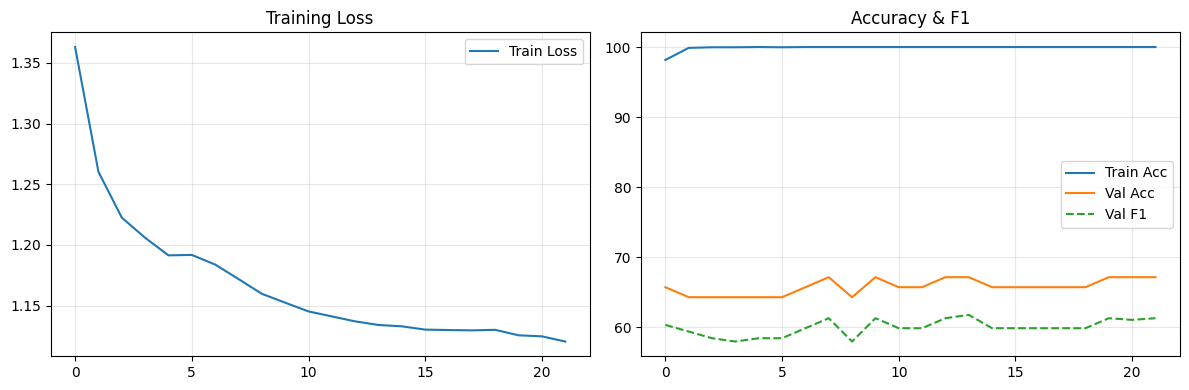

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.title('Training Loss'); plt.grid(alpha=0.3); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.plot([f*100 for f in history['val_f1']], '--', label='Val F1')
plt.title('Accuracy & F1'); plt.grid(alpha=0.3); plt.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "training_history.png", dpi=150)
print(f"\n🎉 Training selesai! Hasil di: {OUTPUT_DIR}")